# QC Long Delay Notebook

Notebook for visualizing and analyzing quadricyclane results at long delays

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.special
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter as gf
from scipy.optimize import curve_fit, dual_annealing, differential_evolution

import h5py
import gued
import gued_theory as gt

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Degrees of freedom <= 0 for slice')

angs = '\u00C5' # Angstrom sign
inv_angs = '($\mathrm{\AA}^{-1}$)'
path_mol='packages/Molecular_coordinates/' # The molecular .xyz/.csv paths


## Import Experimental Data
Reads data from previously existing matlab files

In [2]:
file_path =  "/work/centurion/shared/UED_data/QC_Data/20200911_1229/"
file_name = file_path + "QC_2025-02-08.h5"
group_name = "long_delay"

#print(run_numbers)
run_numbers = 'all'
#run_numbers = [3, 4, 5]
# Don't read in the raw data (clean_images) unless you are not reading all images
variable_names = ["I", "centers", "new_centers", 
                  "normalization_factor",
                  "stage_positions", "total_counts"]
# variable_names = ["I", "stage_positions"]

In [3]:
# Read combined data
combined_data = gued.read_combined_data(file_name, group_name, variable_names, run_numbers=run_numbers)
print(combined_data.keys())
combined_I = combined_data['I']
combined_stage = combined_data['stage_positions']
combined_centers = combined_data['new_centers']
combined_factors = combined_data['normalization_factor']

dict_keys(['I', 'centers', 'new_centers', 'normalization_factor', 'stage_positions', 'total_counts'])


## Set Up Independent variables

In [6]:
uni_stage = np.unique(combined_stage)

s_cali = 0.0243 # S calibration in experiment
angs = '\u00C5' # angstrom sign

posi_0 = 149.53
s = np.arange(0,len(combined_I[0]))*s_cali # The Q axis
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps

In [7]:
realtime

array([199.86   ,  99.93   ,  49.965  ,  19.986  ,   9.993  ,   4.9965 ,
         1.9986 ,   1.49895,   0.9993 ,   0.49965,  -0.     ,  -0.49965,
        -0.9993 ,  -1.49895,  -1.9986 ])

## Bootstrap Sampling Generation

Note, this averages the data for each time bin within the code

In [8]:
def bootstrap_sampling(bins, sample_size,iterations):
    results = []
    for p in range(iterations):
        sample = np.random.choice(bins, size=sample_no, replace=True)
        results.append(sample)
    return results

def generate_bootstrap_sample(data, stage_positions, iterations=100):
    """
    Code for generating n number of bootstrap sampled data sets from an original set and stage positions. Returns an array, averaged by stage position, of 
    n new samples.
    
    ARGUMENTS:
        
    data (array):
        azimuthally averaged scattering signal
    stage_positions (array):
        all stage positions corresponding to data set
    
    RETURNS:
    
    boot_data (array):
        n randomly generated scattering signals for each time delay
    uni_stage (array):
        unique stage positions for experiment
    """
    
    uni_stage = np.unique(stage_positions)
    boot_data = []
    for pos in uni_stage:
        sample = np.where(stage_positions==pos)[0]
        sampled_data = []
        for i in range(0, iterations):
            new_sample = np.random.choice(sample, size=len(sample), replace=True)
            sampled_data.append(np.nanmean(data[new_sample], axis=0))
        boot_data.append(np.array(sampled_data))

    return np.array(boot_data), np.unique(stage_positions)



In [9]:
temp_data, uni_stage = generate_bootstrap_sample(combined_I, combined_stage)
I_boot = temp_data
dI_I_boot = []

for i in range(100):
    azi_data = I_boot[:, i, :]
    n_ref = 5
    ref_data = np.nanmean(azi_data[-n_ref:], axis=0)
    dI_I = (azi_data - ref_data)/ref_data
    dI_I_fixed = gt.fit_high_s(dI_I, s, s_range=300, plot=False)
    dI_I_boot.append(dI_I_fixed)

dI_I_boot = np.array(dI_I_boot)
print(dI_I_boot.shape)

(100, 15, 450)


## Averaging Based on Delay Position

In [25]:
x_centers = combined_centers[:, 0]
y_centers = combined_centers[:, 1]

x_ave = []
y_ave = []
for i in range(len(uni_stage)):
    x_vals = x_centers[np.where(combined_stage==uni_stage[i])[0]]
    y_vals = y_centers[np.where(combined_stage==uni_stage[i])[0]]
    x_ave.append(np.nanmean(x_vals, axis=0))
    y_ave.append(np.nanmean(y_vals, axis=0))

x_ave = np.array(x_ave)
y_ave = np.array(y_ave)

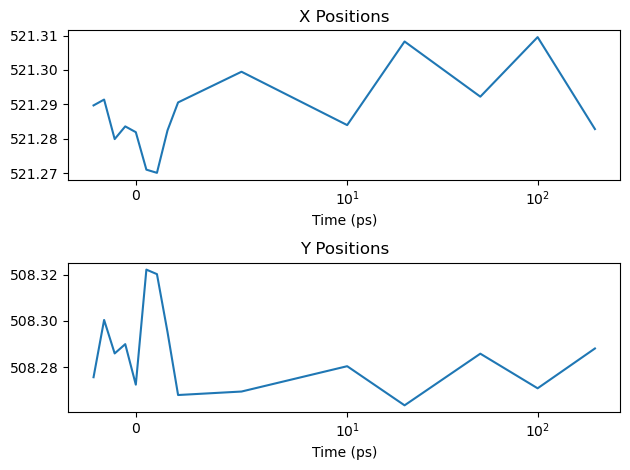

In [29]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(realtime, x_ave)
plt.xscale('symlog', linthresh=10)
plt.xlabel("Time (ps)")
plt.title("X Positions")

plt.subplot(2,1,2)
plt.plot(realtime, y_ave)
plt.xscale('symlog', linthresh=10)
plt.xlabel("Time (ps)")
plt.title("Y Positions")

plt.tight_layout()
plt.show()

## Plot dI/I 

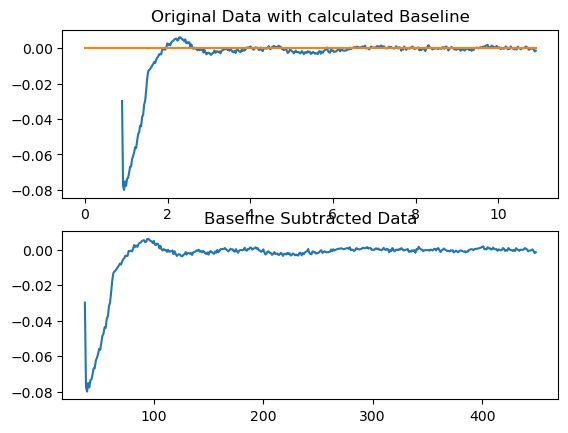

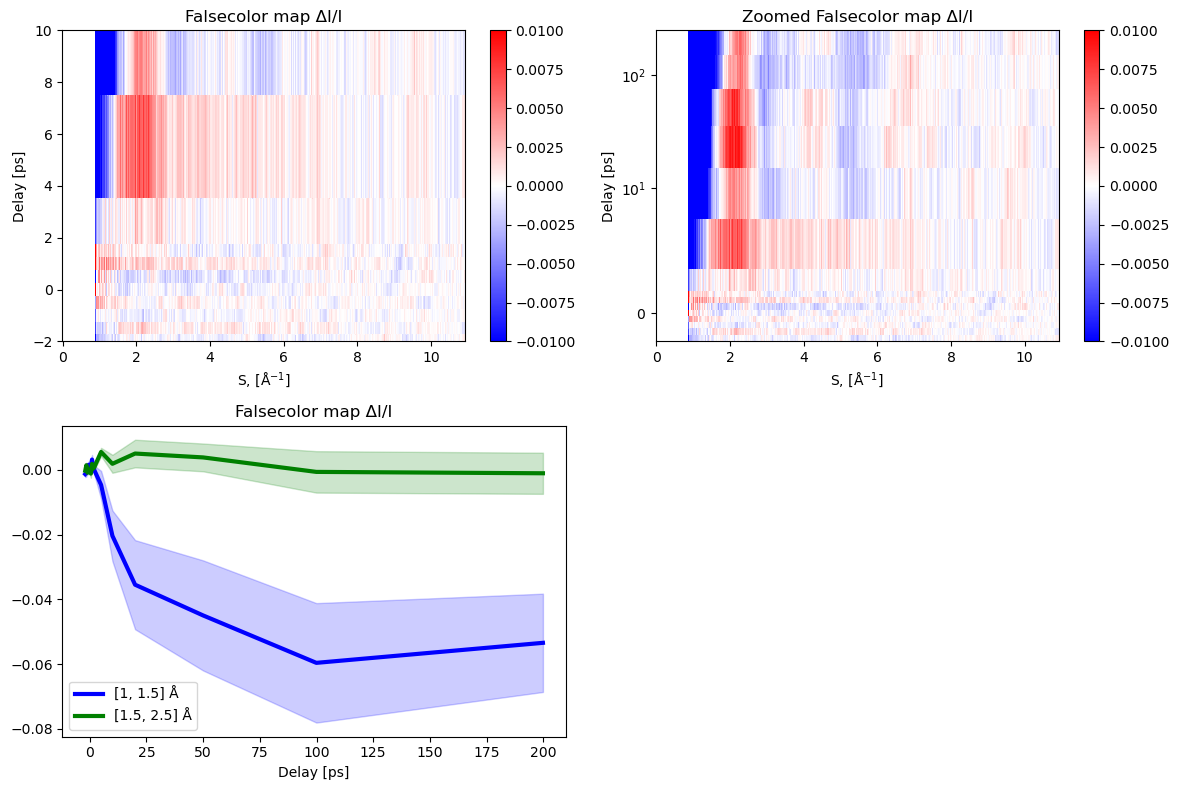

In [13]:
dI_I = np.nanmean(dI_I_boot, axis=0)

#dI_I_fit = gued.poly_fit(dI_I, s, degree=2, plot=True)
dI_I_fit = gt.fit_high_s(dI_I, s, s_range=300, plot=True)
#dI_I_fit = dI_I

# Plot a figure of the time-depdendent signal of scattering percentage difference.

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.pcolor(s,realtime,dI_I_fit,cmap='bwr')
plt.clim(vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.ylim(-2, 10)
#plt.yscale('symlog', linthresh=10)
#plt.ylim(-1)
#plt.xlim(0, 7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_fit,cmap='bwr')
plt.clim(vmin=-0.01, vmax=0.01)
plt.colorbar()
#plt.ylim(-2, 10)
plt.yscale('symlog', linthresh=10)
#plt.xlim(0, 7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Delay [ps]')
plt.title('Zoomed Falsecolor map ΔI/I')

plt.subplot(2,2,3)

RoI_1 = [1, 1.5]
RoI_2 = [1.5, 2.5]

Inte_1 = dI_I_fit[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1)
Inte_2 = dI_I_fit[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1)
std_1 = dI_I_fit[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
std_2 = dI_I_fit[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1)

plt.plot(realtime, Inte_1,'-', color = "blue", linewidth=3, label=str(RoI_1)+' '+angs)
plt.fill_between(realtime, Inte_1-std_1, Inte_1+std_1, color="blue", alpha=0.2)
plt.plot(realtime, Inte_2,'-', color="green", linewidth=3, label=str(RoI_2)+' '+angs)
plt.fill_between(realtime, Inte_2-std_2, Inte_2+std_2, color="green", alpha=0.2)
#plt.xlim(-1, 3)
#plt.xscale('symlog', linthresh=10)
#plt.ylim(-1, 3)
#plt.xlim(108, 110)
plt.legend()
plt.xlabel('Integrated Yield [arb.]')
plt.xlabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')


plt.tight_layout()
plt.show()


## Get Product Ratios

In [14]:
s_temp, frag_dI_new = np.loadtxt("frags.txt", skiprows=1, unpack=True)
_, QC_dI_hot = np.loadtxt("QC.txt", skiprows=1, unpack=True)
_, NB_dI_hot = np.loadtxt("NB.txt", skiprows=1, unpack=True)


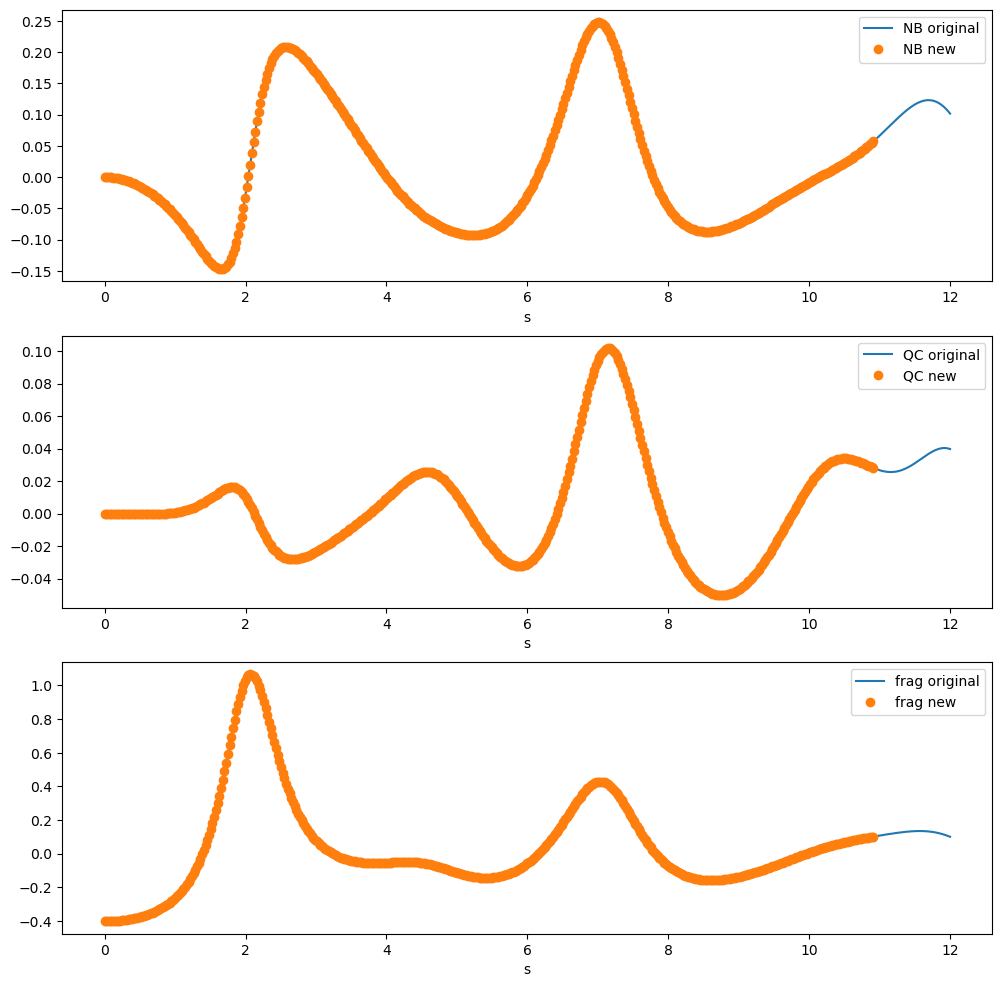

In [15]:
NB_late_new = NB_dI_hot
QC_late_new = QC_dI_hot

# Target array length (we want 100 points in the resampled array)
array2_length = len(s)

# Create an interpolation function for array1 based on its index
x_original = s_temp # Normalized indices for array1
NB_interp_func = interp1d(x_original, NB_late_new, kind='cubic')  # Cubic interpolation
QC_interp_func = interp1d(x_original, QC_late_new, kind='cubic')
frag_interp_func = interp1d(x_original, frag_dI_new, kind='cubic')
# e_interp_func = interp1d(e_scat_s, e_scattering_mean, kind='cubic', bounds_error=False, fill_value="extrapolate")
# Interpolate array1 to match the length of array2
x_target = s # Normalized indices for target length
QC_late_resampled = QC_interp_func(x_target)
NB_late_resampled = NB_interp_func(x_target)
frags_late_resampled = frag_interp_func(x_target)
# e_scat_sig_resampled = e_interp_func(x_target)

# Plot the original and resampled arrays
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(s_temp, NB_late_new, "-", label="NB original")
plt.plot(s, NB_late_resampled, "o", label="NB new")
plt.xlabel("s")
plt.legend()


plt.subplot(3,1,2)
plt.plot(s_temp, QC_late_new, "-", label="QC original")
plt.plot(s, QC_late_resampled, "o", label="QC new")
plt.xlabel("s")
plt.legend()

plt.subplot(3,1,3)
plt.plot(s_temp, frag_dI_new, "-", label="frag original")
plt.plot(s, frags_late_resampled, "o", label="frag new")
plt.xlabel("s")
plt.legend()

# plt.subplot(4,1,4)
# plt.plot(e_scat_s, e_scat_sig, "-", label="electronic original")
# plt.plot(s_simu, e_scat_sig_resampled, "o", label="electronic new")
# plt.xlabel("s")
# plt.legend()

plt.show()


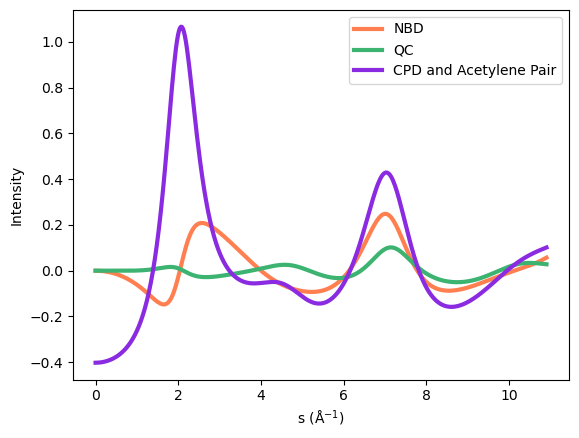

In [16]:
plt.figure()
plt.plot(s, NB_late_resampled, color="coral", linewidth=3, label="NBD")
plt.plot(s, QC_late_resampled, color="mediumseagreen", linewidth=3, label="QC")
# plt.plot(s_simu, frag_simu, label="Fragments Hot")
plt.plot(s, frags_late_resampled, color="blueviolet", linewidth=3, label="CPD and Acetylene Pair")
# plt.plot(s_simu, frag_alt, label="Fragments other?")
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.legend()
plt.show()

## Fitting Average of Bootstrap

In [17]:
def zero_correction(x_data, y_data, theory_data):
    zero_crossings = np.where(np.diff(np.sign(theory_data)))[0]
    
    if zero_crossings.size == 0:  # No zero crossings found
        #print("Warning: No zero crossings found. Returning uncorrected data.")
        return np.zeros_like(x_data), y_data  # No baseline correction
    # for zero in zero_crossings:
    #     print(y_data[zero+10]+y_data[zero-10])
    # Proceed with zero-crossing-based correction
    #print(f"Found zeros at {x_data[zero_crossings]}")
    coeffs = np.polyfit(x_data[zero_crossings], y_data[zero_crossings], 2)
    baseline = np.polyval(coeffs, x_data)
    fixed_data = y_data - baseline
    #fixed_data = y_data
    return baseline, fixed_data


In [18]:
s_min = 1.5
s_max = 9.5
s_idx = np.where((s > s_min) & (s < s_max))[0]
bound_max = .01
#print(s_idx)

def model(x, a, b, c):
    fit_result = a*(QC_late_resampled[s_idx]) + b*(NB_late_resampled[s_idx]) + c*(frags_late_resampled[s_idx])

    return fit_result

def cost_func(params):
    return np.sum((ave_data-model(x_data, *params))**2)

def zero_fit_cost_func(params, x_data, y_data, std_data):
    theory_line = model(x_data, *params)
    _, corrected_data = zero_correction(x_data, y_data, theory_line)
    residuals = corrected_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

def weighted_cost_func(params, x_data, y_data, std_data):
    residuals = y_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

x_data = s[s_idx]
print(dI_I_boot.shape)

late_data = np.array(np.nanmean(dI_I_boot[0:6,:, :], axis=0))
print(late_data.shape)
late_data_std = np.nanstd(late_data, axis=0)
late_data_std = late_data_std[s_idx]
print(f"shape of std of late data matrix {late_data_std.shape}")
y_data = np.nanmean(late_data, axis=0)[s_idx]
ave_data = np.nanmean(late_data, axis=0)[s_idx]
print(ave_data.shape)
print(y_data.shape)
print(x_data.shape)

# Gradient Based Curve Fit
bounds = ([0, 0, 0], [bound_max, bound_max, bound_max])
#Fit the data using curve_fit
popt, pcov = curve_fit(model, x_data, ave_data, sigma=late_data_std, bounds=bounds)

print(f"curve fit found values of a, b, c = {popt}")

perc_QC = (popt[0]/sum(popt))*100
perc_NB = (popt[1]/sum(popt))*100
perc_frags = (popt[2]/sum(popt))*100

perc_fit_line = model(x_data, *popt)


rmse = np.sqrt(np.nanmean(ave_data-perc_fit_line)**2)
print("Results from Basic Curve Fit \n")
print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n")

# Simulated Annealing 

print("Results from Dual Annealing \n")
bounds = [(0, bound_max), (0, bound_max), (0, bound_max)]
result = dual_annealing(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std), no_local_search=True)
sa_params = result.x
print(f"dual annealing found results of a, b, c = {sa_params}")
print(result)

perc_QC = (popt[0]/sum(popt))*100
perc_NB = (popt[1]/sum(popt))*100
perc_frags = (popt[2]/sum(popt))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n")

# PSO
print("Results from Differential Evolution \n")
bounds = [(0, bound_max), (0, bound_max), (0, bound_max)]
result = differential_evolution(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std))
sa_params = result.x
print(f"differential evolution found results of a, b, c d= {sa_params}")
print(result)

perc_QC = (popt[0]/sum(popt))*100
perc_NB = (popt[1]/sum(popt))*100
perc_frags = (popt[2]/sum(popt))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags}")

(100, 15, 450)
(15, 450)
shape of std of late data matrix (329,)
(329,)
(329,)
(329,)
curve fit found values of a, b, c = [1.04283877e-12 1.21990901e-12 1.00849951e-03]
Results from Basic Curve Fit 

RMSE = 0.00010279642438455549
 percent QC = 1.0340498540123737e-07 
 percent NBD = 1.2096277693423915e-07 
 percent fragments = 99.99999977563225 

Results from Dual Annealing 

dual annealing found results of a, b, c = [1.73008439e-05 4.30898607e-06 1.00538093e-03]
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 41.27667089967224
       x: [ 1.730e-05  4.309e-06  1.005e-03]
     nit: 1000
    nfev: 6001
    njev: 0
    nhev: 0
RMSE = 4.0411023282072616e-05
 percent QC = 1.0340498540123737e-07 
 percent NBD = 1.2096277693423915e-07 
 percent fragments = 99.99999977563225 

Results from Differential Evolution 

differential evolution found results of a, b, c d= [0.        0.        0.0010085]
 message: Optimization terminated successfully.
 success: Tr

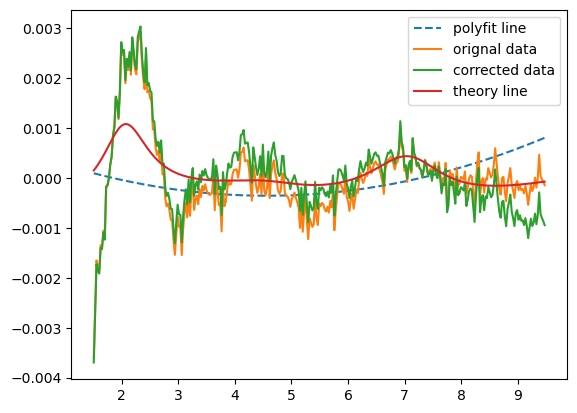

In [19]:
baseline, new_data = zero_correction(x_data, ave_data, perc_fit_line)

plt.figure()
plt.plot(x_data, baseline, "--", label="polyfit line")
plt.plot(x_data, ave_data, label="orignal data")
plt.plot(x_data, new_data, label="corrected data")
plt.plot(x_data, perc_fit_line, label="theory line")
plt.legend()
plt.show()

## Fitting Each Time Step

In [20]:
# reshaping dI_I array
dI_I_boot = dI_I_boot.transpose(2, 1, 0)
print(dI_I_boot.shape)
time_exp = realtime

# Initialize dictionaries to store averages and standard deviations
keys = ["perc_QC", "perc_NB", "perc_frags", "excitation_perc", "fits", "rmse", "chi_sq", "corrected_data", "fails"]
combined_averages = {
    "all_results": {key: [] for key in keys},
    "anneal_results": {key: [] for key in keys},
    "pso_results": {key: [] for key in keys},
}

combined_stds = {
    "all_results": {key: [] for key in keys},
    "anneal_results": {key: [] for key in keys},
    "pso_results": {key: [] for key in keys},
}

fit_idx = np.arange(0, len(time_exp), 1)
#fit_idx = np.where(time_exp>-1)[0]
#print(fit_idx)
for idx in fit_idx:  # Loop 6 times
    # Reinitialize results dictionaries for each iteration
    all_results = {key: [] for key in keys}
    anneal_results = {key: [] for key in keys}
    pso_results = {key: [] for key in keys}
    
    late_data = np.array(dI_I_boot[:, idx, :])  # Example dataset for each loop
    print(f"Starting fitting for round {idx}")

    for j in range(100):  # Loop through data points
        y_data = late_data[s_idx, j]

        # Perform curve fitting
        bounds = ([0., 0., 0.], [1, 1, 1])
        popt, pcov = curve_fit(model, x_data, y_data, sigma=late_data_std, bounds=bounds)

        # Calculate percentages
        perc_QC = popt[0]
        perc_NB = popt[1]
        perc_frags = popt[2]

        perc_fit_line = model(x_data, *popt)

        # Append results to all_results
        all_results["perc_QC"].append(perc_QC/sum(popt))
        all_results["perc_NB"].append(perc_NB/sum(popt))
        all_results["perc_frags"].append(perc_frags/sum(popt))
        all_results["fits"].append(perc_fit_line)
        all_results['excitation_perc'].append(sum(popt))

        rmse = np.sqrt(np.nanmean((y_data - perc_fit_line) ** 2))
        all_results["rmse"].append(rmse)
        chi_sq = np.sum(((y_data - perc_fit_line) ** 2) / (late_data_std ** 2)) / (len(y_data) - 3)
        all_results["chi_sq"].append(chi_sq)

        # Dual Annealing fit
        result = dual_annealing(
            zero_fit_cost_func, bounds=[(0., 1)] * 3, args=(x_data, y_data, late_data_std), no_local_search=True
        )
        sa_params = result.x
        anneal_results["fails"].append(1 if result.nit == 1000 else 0)

        perc_fit_line = model(x_data, *sa_params)
        anneal_results["perc_QC"].append(sa_params[0]/sum(sa_params))
        anneal_results["perc_NB"].append(sa_params[1]/sum(sa_params))
        anneal_results["perc_frags"].append(sa_params[2]/sum(sa_params))
        anneal_results["fits"].append(perc_fit_line)
        anneal_results['excitation_perc'].append(sum(sa_params))

        # Append corrected data
        _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
        anneal_results["corrected_data"].append(corrected_data)

        # Differential Evolution fit
        result = differential_evolution(
            zero_fit_cost_func, bounds=[(0., 1)] * 3, args=(x_data, y_data, late_data_std), maxiter=2000
        )
        sa_params = result.x
        #print(sa_params)
        pso_results["fails"].append(1 if result.nit == 2000 else 0)

        perc_fit_line = model(x_data, *sa_params)
        pso_results["perc_QC"].append(sa_params[0]/sum(sa_params))
        pso_results["perc_NB"].append(sa_params[1]/sum(sa_params))
        pso_results["perc_frags"].append(sa_params[2]/sum(sa_params))
        pso_results["fits"].append(perc_fit_line)
        pso_results['excitation_perc'].append(sum(sa_params))

        # Append corrected data
        _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
        pso_results["corrected_data"].append(corrected_data)

    # Combine results into averages and standard deviations
    temp_dict = {
        "all_results": all_results,
        "anneal_results": anneal_results,
        "pso_results": pso_results,
    }

    for name, data in temp_dict.items():
        for key, values in data.items():
            if len(values) > 0:  # Ensure the key has values to process
                if key == "fails":
                    # Append sum for 'fails'
                    combined_averages[name][key].append(np.sum(values, axis=0))
                    combined_stds[name][key].append(None)  # Standard deviation doesn't apply to sums
                else:
                    # Append mean and standard deviation
                    combined_averages[name][key].append(np.nanmean(values, axis=0))
                    combined_stds[name][key].append(np.nanstd(values, axis=0))

# Output combined results
# print("Combined Averages:", combined_averages)
# print("Combined Standard Deviations:", combined_stds)
print("Done")


(450, 15, 100)
Starting fitting for round 0
Starting fitting for round 1
Starting fitting for round 2
Starting fitting for round 3
Starting fitting for round 4
Starting fitting for round 5
Starting fitting for round 6
Starting fitting for round 7
Starting fitting for round 8
Starting fitting for round 9
Starting fitting for round 10
Starting fitting for round 11
Starting fitting for round 12
Starting fitting for round 13
Starting fitting for round 14
Done


In [21]:
for i in range(len(combined_averages['pso_results']['perc_QC'])):
    print(f"PSO fitting results for time {i} \n \
      % QC = {combined_averages['pso_results']['perc_QC'][i]} +/- {combined_stds['pso_results']['perc_QC'][i]} \n \
      % NB = {combined_averages['pso_results']['perc_NB'][i]} +/- {combined_stds['pso_results']['perc_NB'][i]} \n \
      % frags = {combined_averages['pso_results']['perc_frags'][i]} +/- {combined_stds['pso_results']['perc_frags'][i]}")
      
    print(f"Anneal fitting results for time {i} \n \
      % QC = {combined_averages['anneal_results']['perc_QC'][i]} +/- {combined_stds['anneal_results']['perc_QC'][i]} \n \
      % NB = {combined_averages['anneal_results']['perc_NB'][i]} +/- {combined_stds['anneal_results']['perc_NB'][i]} \n \
      % frags = {combined_averages['anneal_results']['perc_frags'][i]} +/- {combined_stds['anneal_results']['perc_frags'][i]}")

PSO fitting results for time 0 
       % QC = 0.6116624186564724 +/- 0.2385284926383789 
       % NB = 0.21227846356028607 +/- 0.20558436299263394 
       % frags = 0.17605911778324151 +/- 0.17521865586061486
Anneal fitting results for time 0 
       % QC = 0.5550823852192295 +/- 0.2667068658942477 
       % NB = 0.1870746733673548 +/- 0.19243475408005561 
       % frags = 0.25784294141341557 +/- 0.23908711767066637
PSO fitting results for time 1 
       % QC = 0.38328480393814546 +/- 0.2646038411920068 
       % NB = 0.3064869692707114 +/- 0.28726617085623524 
       % frags = 0.31022822679114326 +/- 0.24969406695469348
Anneal fitting results for time 1 
       % QC = 0.47229679804868163 +/- 0.27935023591725155 
       % NB = 0.2602293322390501 +/- 0.24660596487445985 
       % frags = 0.2674738697122682 +/- 0.21860027315974057
PSO fitting results for time 2 
       % QC = 0.4527124659760134 +/- 0.31697885341790144 
       % NB = 0.1951547274385126 +/- 0.19932262609696957 
       % fr

In [59]:
np.max(combined_averages['anneal_results']['excitation_perc'])

0.018100744707304706

In [67]:
pso_ave_fit = np.mean(combined_averages['pso_results']['fits'], axis=0)
print(pso_ave_fit.shape)

new_pso_percent_QC = []
new_pso_std_QC = []
new_pso_percent_NB = []
new_pso_std_NB = []
new_pso_percent_frags = []
new_pso_std_frags = []
new_an_percent_QC = []
new_an_percent_NB = []
new_an_percent_frags = []
new_an_std_QC = []
new_an_std_NB = []
new_an_std_frags = []


for i in range(len(combined_averages['pso_results']['excitation_perc'])):
    new_pso_percent_QC.append(combined_averages['pso_results']['excitation_perc'][i]*
                              combined_averages['pso_results']['perc_QC'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_percent_NB.append(combined_averages['pso_results']['excitation_perc'][i]*
                              combined_averages['pso_results']['perc_NB'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_percent_frags.append(combined_averages['pso_results']['excitation_perc'][i]*
                                 combined_averages['pso_results']['perc_frags'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_std_QC.append(combined_averages['pso_results']['excitation_perc'][i]*
                          combined_stds['pso_results']['perc_QC'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_std_NB.append(combined_averages['pso_results']['excitation_perc'][i]*
                          combined_stds['pso_results']['perc_NB'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_std_frags.append(combined_averages['pso_results']['excitation_perc'][i]*
                             combined_stds['pso_results']['perc_frags'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    
    new_an_percent_QC.append(combined_averages['anneal_results']['excitation_perc'][i]*
                             combined_averages['anneal_results']['perc_QC'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_percent_NB.append(combined_averages['anneal_results']['excitation_perc'][i]*
                             combined_averages['anneal_results']['perc_NB'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_percent_frags.append(combined_averages['anneal_results']['excitation_perc'][i]*
                                combined_averages['anneal_results']['perc_frags'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_std_QC.append(combined_averages['anneal_results']['excitation_perc'][i]*
                         combined_stds['anneal_results']['perc_QC'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_std_NB.append(combined_averages['anneal_results']['excitation_perc'][i]*
                         combined_stds['anneal_results']['perc_NB'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_std_frags.append(combined_averages['anneal_results']['excitation_perc'][i]*
                            combined_stds['anneal_results']['perc_frags'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))

new_pso_percent_QC = np.array(new_pso_percent_QC)
new_pso_percent_NB = np.array(new_pso_percent_NB)
new_pso_percent_frags = np.array(new_pso_percent_frags)
new_pso_std_QC = np.array(new_pso_std_QC)
new_pso_std_NB = np.array(new_pso_std_NB)
new_pso_std_frags = np.array(new_pso_std_frags)
new_an_percent_QC = np.array(new_an_percent_QC)
new_an_percent_NB = np.array(new_an_percent_NB)
new_an_percent_frags = np.array(new_an_percent_frags)
new_an_std_QC = np.array(new_an_std_QC)
new_an_std_NB = np.array(new_an_std_NB)
new_an_std_frags = np.array(new_an_std_frags)

for i in range(len(new_pso_percent_frags)):
    print(time_exp[i], (new_pso_percent_QC[i] + new_pso_percent_NB[i] + new_pso_percent_frags[i]))
    print(time_exp[i], (new_an_percent_QC[i] + new_an_percent_NB[i] + new_an_percent_frags[i]))

(366,)
1.0042965333332177 0.7281859108548031
1.0042965333332177 0.7211492486100821
0.9373433999998801 0.8685060339335429
0.9373433999998801 0.8844016354333903
0.8703903333332619 0.8795274924736558
0.8703903333332619 0.9233526344847007
0.8034372666666437 0.8673056443795266
0.8034372666666437 0.9092271184146332
0.7364841333333061 1.0000000000000002
0.7364841333333061 1.0000000000000002
0.6695310666664985 0.6243728343612643
0.6695310666664985 0.6559108507129181
0.6025779333331608 0.5185971682061858
0.6025779333331608 0.5483881532246931
0.5356247999998232 0.4646378757616936
0.5356247999998232 0.4979598578537364
0.46867173333320505 0.4484481593252343
0.46867173333320505 0.483486079592588
0.4017185999998674 0.6503289971473871
0.4017185999998674 0.6918270301281264
0.33476553333324927 0.36678434537764615
0.33476553333324927 0.49050417678806735
0.2678124666666311 0.20394271699581412
0.2678124666666311 0.3522987004691207
0.20085933333329345 0.0589319173768787
0.20085933333329345 0.22242582932567

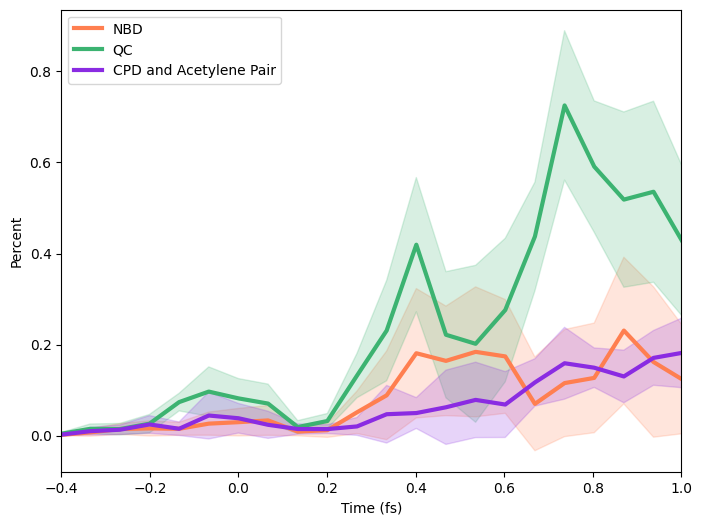

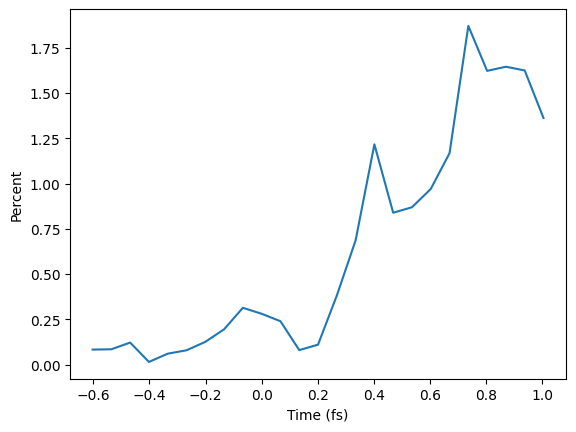

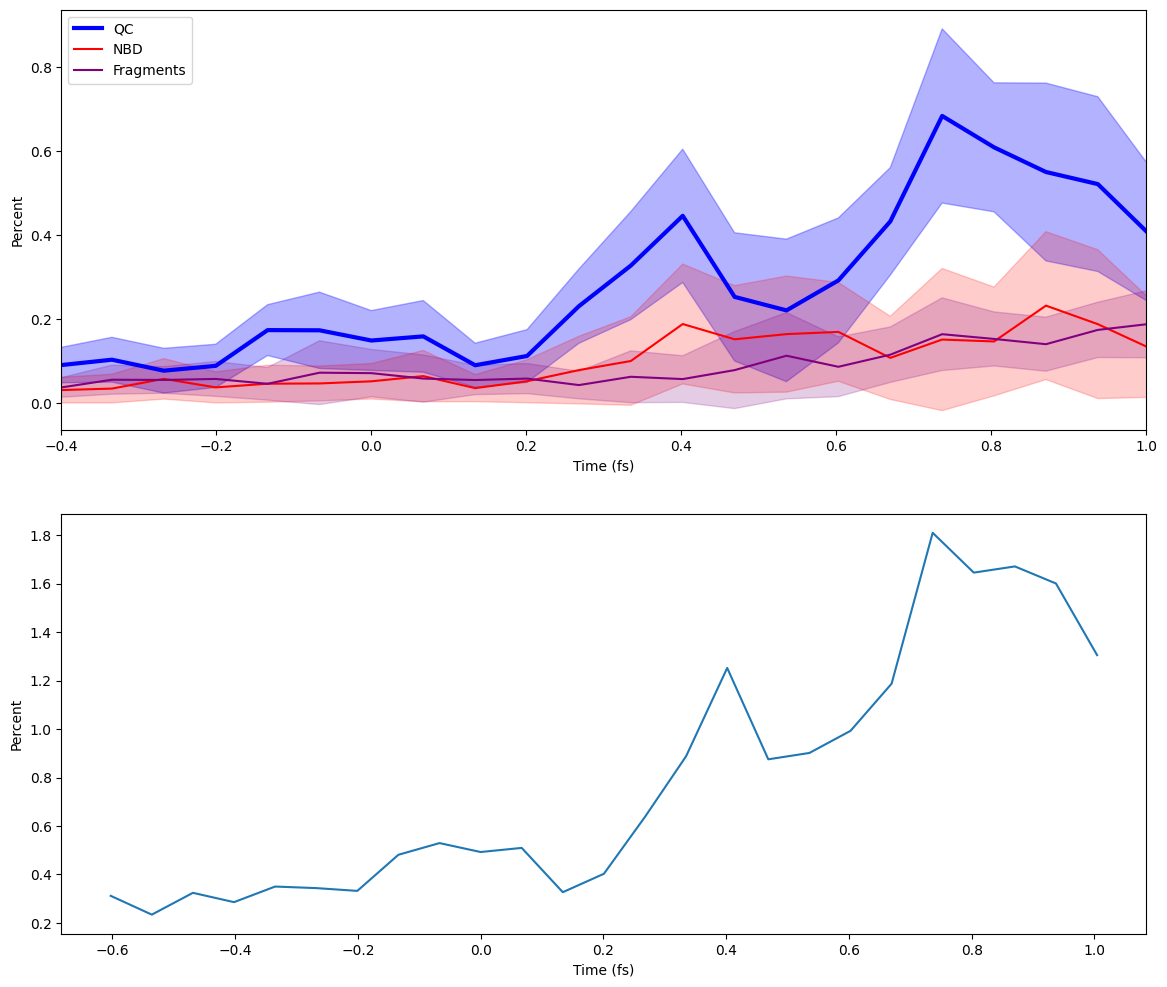

In [63]:
plt.figure(figsize=(8,6))
# plt.subplot(2,1,1)
plt.plot(time_exp[fit_idx], new_pso_percent_NB, color="coral", linewidth=3, label="NBD")
plt.fill_between(time_exp[fit_idx], new_pso_percent_NB-new_pso_std_NB,
                 new_pso_percent_NB+new_pso_std_NB, alpha=0.2, color='coral')
plt.plot(time_exp[fit_idx], new_pso_percent_QC, color='mediumseagreen', linewidth=3, label="QC")
plt.fill_between(time_exp[fit_idx], new_pso_percent_QC - new_pso_std_QC,
                 new_pso_percent_QC+new_pso_std_QC, alpha=0.2, color='mediumseagreen')
plt.plot(time_exp[fit_idx], new_pso_percent_frags, color="blueviolet", linewidth=3, label="CPD and Acetylene Pair")
plt.fill_between(time_exp[fit_idx], new_pso_percent_frags-new_pso_std_frags,
                 new_pso_percent_frags+new_pso_std_frags, alpha=0.2, color='blueviolet')
#plt.plot(time_exp[fit_idx], np.sum((new_pso_percent_NB, new_pso_percent_QC, new_pso_percent_frags), axis=0), color="green", label="total")
plt.legend()
plt.xlabel("Time (fs)")
plt.xlim(-0.4, 1)
plt.ylabel("Percent")

# plt.subplot(2,1,2)
plt.figure()
plt.plot(time_exp[fit_idx], np.array(combined_averages['pso_results']['excitation_perc'])*100)
plt.xlabel("Time (fs)")
plt.ylabel("Percent")
plt.show()

plt.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.plot(time_exp[fit_idx], new_an_percent_QC, color='blue', linewidth=3, label="QC")
plt.fill_between(time_exp[fit_idx], new_an_percent_QC - new_an_std_QC,
                 new_an_percent_QC+new_an_std_QC, alpha=0.3, color='blue')
plt.plot(time_exp[fit_idx], new_an_percent_NB, color="red", label="NBD")
plt.fill_between(time_exp[fit_idx], new_an_percent_NB-new_an_std_NB,
                 new_an_percent_NB+new_an_std_NB, alpha=0.2, color='red')
plt.plot(time_exp[fit_idx], new_an_percent_frags, color="purple", label="Fragments")
plt.fill_between(time_exp[fit_idx], new_an_percent_frags-new_an_std_frags,
                 new_an_percent_frags+new_an_std_frags, alpha=0.2, color='purple')
#plt.plot(time_exp[fit_idx], np.sum((new_an_percent_NB, new_an_percent_QC, new_an_percent_frags), axis=0), color="green", label="total")
plt.legend()
plt.xlim(-0.4,1)
plt.xlabel("Time (fs)")
plt.ylabel("Percent")

plt.subplot(2,1,2)
plt.plot(time_exp[fit_idx], np.array(combined_averages['anneal_results']['excitation_perc'])*100)
plt.xlabel("Time (fs)")
plt.ylabel("Percent")
plt.show()

In [64]:
def calculate_total_std(std_devs):
    """
    Calculate the total standard deviation for multiple datasets with the same sample size.

    Parameters:
        std_devs (list of float): Standard deviations of the datasets.

    Returns:
        float: Total standard deviation.
    """
    if len(std_devs) == 0:
        raise ValueError("std_devs list cannot be empty.")
    
    variance_sum = sum(s ** 2 for s in std_devs)
    total_std_dev = np.sqrt(variance_sum / len(std_devs))
    return total_std_dev

#print(combined_stds['all_results']['fits'])
# ave_fits_std = calculate_total_std(combined_stds['all_results']['fits'])
# print(ave_fits_std.shape)

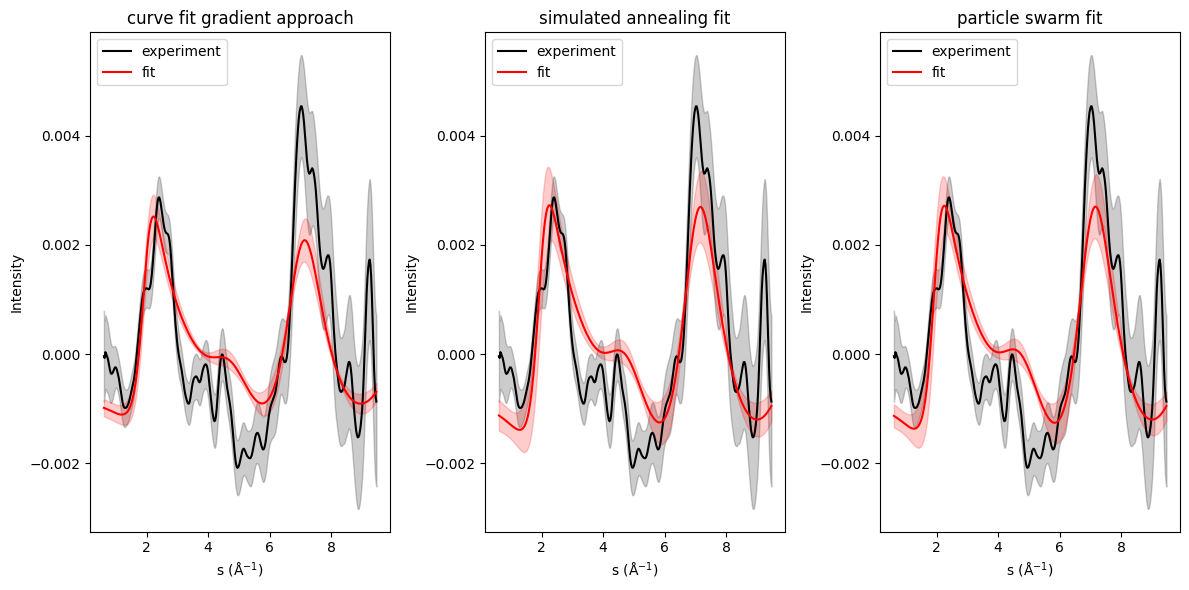

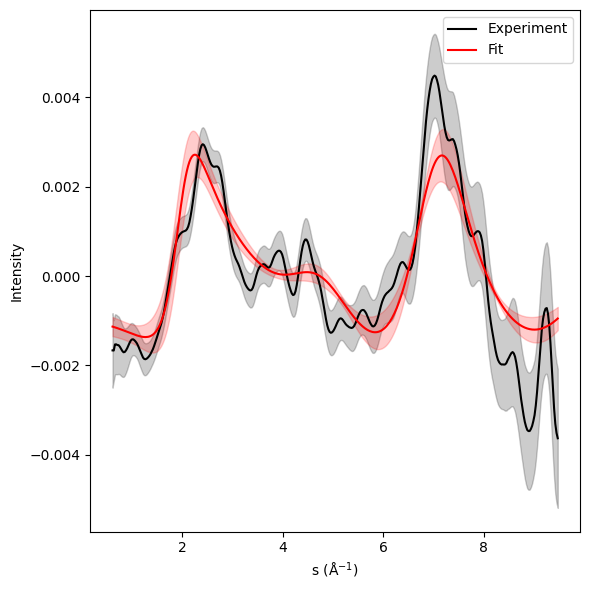

ANNEALING
 percent QC = 0.6264384545761682 +/- 0.21158042829830573 
 percent NBD = 0.18711560441691957 +/- 0.17086037166765972 
 percent fragments = 0.18644594100691228        +/- 0.08726940268391233 
 total percent = 1.0
RMSE = 7.064128178659567e-05
PARTICLE SWARM
 percent QC = 64.92198710943283 +/- 20.068615279020644 
 percent NBD = 16.512165292580697 +/- 16.125165400633502 
 percent fragments = 18.56584759798647        +/- 7.748502167480227 
 total percent = 100.0
RMSE = 6.815959714306259e-05


In [69]:
ave_exp = np.mean(np.nanmean(np.array(dI_I_boot[:, 0:6, :]), axis=1), axis=1)[s_idx]

ave_fits = np.mean(np.array(combined_averages['all_results']['fits'][0:6]), axis=0)
ave_fits_std = calculate_total_std(combined_stds['all_results']['fits'][0:6])

ave_anneal = np.mean(np.array(combined_averages['anneal_results']['fits'][0:6]), axis=0)
ave_anneal_std = calculate_total_std(combined_stds['anneal_results']['fits'][0:6])

ave_pso = np.mean(np.array(combined_averages['pso_results']['fits'][0:6]), axis=0)
ave_pso_std = calculate_total_std(combined_stds['pso_results']['fits'][0:6])


plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_fits, color='r', label="fit")
plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
# plt.axvline(s_min)
# plt.axvline(s_max)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("curve fit gradient approach")
plt.legend()

plt.subplot(1,3,2)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_anneal, color='r', label="fit")
plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("simulated annealing fit")
plt.legend()

plt.subplot(1,3,3)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

ave_anneal_corrected = np.mean(np.array(combined_averages['anneal_results']['corrected_data'][0:6]), axis=0)

ave_pso_corrected = np.mean(np.array(combined_averages['pso_results']['corrected_data'][0:6]), axis=0)



plt.figure(figsize=(6, 6))

# plt.subplot(1,3,1)
# plt.plot(x_data, ave_exp, color='k', label="experiment")
# plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
# plt.plot(x_data, ave_fits, color='r', label="fit")
# plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
# # plt.axvline(s_min)
# # plt.axvline(s_max)
# plt.ylabel("Intensity")
# plt.xlabel(f"s {inv_angs}")
# plt.title("curve fit gradient approach")
# plt.legend()

# plt.subplot(1,2,1)
# plt.plot(x_data, ave_anneal_corrected, color='k', label="experiment")
# plt.fill_between(x_data, ave_anneal_corrected-late_data_std, ave_anneal_corrected+late_data_std, color='k', alpha=0.2)
# plt.plot(x_data, ave_anneal, color='r', label="fit")
# plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
# plt.ylabel("Intensity")
# plt.xlabel(f"s {inv_angs}")
# plt.title("simulated annealing fit")
# plt.legend()

# plt.subplot(1,2,2)
plt.plot(x_data, ave_pso_corrected, color='k', label="Experiment")
plt.fill_between(x_data, ave_pso_corrected-late_data_std, ave_pso_corrected+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="Fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
#plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

ave_perc_QC = np.mean(np.array(combined_averages['all_results']['perc_QC']))
std_perc_QC = calculate_total_std(combined_stds['all_results']['perc_QC'])
ave_perc_NB = np.mean(np.array(combined_averages['all_results']['perc_NB']))
std_perc_NB = calculate_total_std(combined_stds['all_results']['perc_NB'])
ave_perc_frags = np.mean(np.array(combined_averages['all_results']['perc_frags']))
std_perc_frags = calculate_total_std(combined_stds['all_results']['perc_frags'])

ave_anneal_QC = np.mean(np.array(combined_averages['anneal_results']['perc_QC'][0:6]))
std_anneal_QC = calculate_total_std(combined_stds['anneal_results']['perc_QC'][0:6])
ave_anneal_NB = np.mean(np.array(combined_averages['anneal_results']['perc_NB'][0:6]))
std_anneal_NB = calculate_total_std(combined_stds['anneal_results']['perc_NB'][0:6])
ave_anneal_frags = np.mean(np.array(combined_averages['anneal_results']['perc_frags'][0:6]))
std_anneal_frags = calculate_total_std(combined_stds['anneal_results']['perc_frags'][0:6])
# ave_pso_QC = np.mean(pso_perc_QC[good_idx])
# std_pso_QC = np.std(pso_perc_QC[good_idx])
# ave_pso_NB = np.mean(pso_perc_NB[good_idx])
# std_pso_NB = np.std(pso_perc_NB[good_idx])
# ave_pso_frags = np.mean(pso_perc_frag[good_idx])
# std_pso_frags = np.std(pso_perc_frag[good_idx])

# ave_pso_QC = np.mean(new_pso_percent_QC[0:6])*100
# std_pso_QC = calculate_total_std(new_pso_std_QC[0:6])*100
# ave_pso_NB = np.mean(new_pso_percent_NB[0:6])*100
# std_pso_NB = calculate_total_std(new_pso_std_NB[0:6])*100
# ave_pso_frags = np.mean(new_pso_percent_frags[0:6])*100
# std_pso_frags = calculate_total_std(new_pso_std_frags[0:6])*100

ave_pso_QC = np.mean(combined_averages['pso_results']['perc_QC'][0:6])*100
std_pso_QC = calculate_total_std(combined_stds['pso_results']['perc_QC'][0:6])*100
ave_pso_NB = np.mean(combined_averages['pso_results']['perc_NB'][0:6])*100
std_pso_NB = calculate_total_std(combined_stds['pso_results']['perc_NB'][0:6])*100
ave_pso_frags = np.mean(combined_averages['pso_results']['perc_frags'][0:6])*100
std_pso_frags = calculate_total_std(combined_stds['pso_results']['perc_frags'][0:6])*100


# print("CURVE FIT")
# print(f" percent QC = {ave_perc_QC} +/- {std_perc_QC} \n percent NBD = {ave_perc_NB} +/- {std_perc_NB} \n percent fragments = {ave_perc_frags} \
#       +/- {std_perc_frags} \n total percent = {ave_perc_QC+ave_perc_NB+ave_perc_frags}")
# rmse = np.sqrt(np.nanmean(ave_exp-ave_fits)**2)
# print(f"RMSE = {rmse}")
print("ANNEALING")
print(f" percent QC = {ave_anneal_QC} +/- {std_anneal_QC} \n percent NBD = {ave_anneal_NB} +/- {std_anneal_NB} \n percent fragments = {ave_anneal_frags} \
       +/- {std_anneal_frags} \n total percent = {ave_anneal_QC+ave_anneal_NB+ave_anneal_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_anneal)**2)
print(f"RMSE = {rmse}")
print("PARTICLE SWARM")
print(f" percent QC = {ave_pso_QC} +/- {std_pso_QC} \n percent NBD = {ave_pso_NB} +/- {std_pso_NB} \n percent fragments = {ave_pso_frags} \
       +/- {std_pso_frags} \n total percent = {ave_pso_QC+ave_pso_NB+ave_pso_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_pso)**2)
print(f"RMSE = {rmse}")

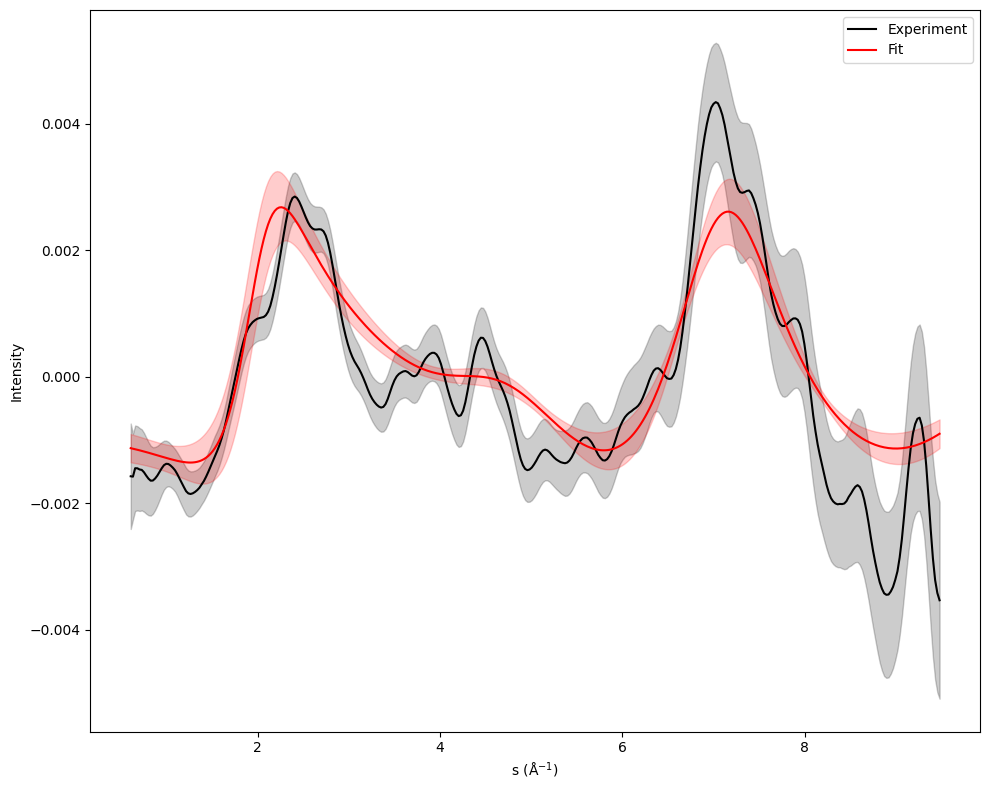

In [59]:
plt.figure(figsize=(10,8))
plt.plot(x_data, ave_pso_corrected, color='k', label="Experiment")
plt.fill_between(x_data, ave_pso_corrected-late_data_std, ave_pso_corrected+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="Fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
#plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()